In [1]:
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
from simpledbf import Dbf5
import matplotlib.pyplot as plt
import shapefile
import matplotlib as mpl
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import matplotlib.cm as cm
import time
from descartes.patch import PolygonPatch

SQLalchemy is not installed. No support for SQL output.


In [5]:
census_block_pd = pd.read_csv('./data/net_am_peak/block_am_closest_node.csv',dtype={'GEOID10':str})

In [6]:
block_point_pd = census_block_pd.set_index('GEOID10')

In [7]:
sf = shapefile.Reader('./data/tl_2010_06037_tabblock10/tl_2010_06037_tabblock10')

In [8]:
geo_records = pd.DataFrame(sf.records())
geo_records.reset_index(inplace=True)
geo_records = geo_records[['index', 4]]

In [9]:
shapeRecs = sf.shapeRecords()

In [10]:
# small (W 118°19'29"--W 118°13'02"/N 34°04'26"--N 34°00'26") 
def outsideBox(geoid):
    lat = block_point_pd.loc[geoid,'INTPTLAT10']
    lon = block_point_pd.loc[geoid,'INTPTLON10']
    if lat < 33.8 or lat > 34.25 or lon < -118.7 or lon > -118.0: #big
    #if lat < 34.00 or lat > 34.06 or lon < -118.30 or lon > -118.25: #small
        return True
    return False

In [13]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [25]:
#max_job_num = 2947601 #am_all_60
#mean_job_num = 1157403.0 #am_all_mean_60
#max_job_num = 1966269 #am_all_40
#mean_job_num = 479523.0 #am_all_mean_40
max_job_num =751009 #am_all_20
mean_job_num = 76435.0 #mean_all_20
#max_job_num = 799529 #am_above_40
#max_job_num = 2317561 #mid_all_60
#max_job_num = 485437 #mid_above_40
#max_job_num = 2511688 #pm_all_60
#max_job_num = 572981 #pm_above_40
#max_job_num = 452988 #night_all_60
#max_job_num = 206282 #night_above_60
min_job_num = 0
norm = mpl.colors.Normalize(vmin=min_job_num, vmax=max_job_num)
cmap = plt.get_cmap('gist_stern_r')
#cmap = plt.get_cmap('seismic') # for standard deviation
#cmap = shiftedColorMap(cmap, midpoint=mean_job_num/max_job_num) # for standard deviation
scmap = cm.ScalarMappable(norm=norm,cmap=newmap)

In [18]:
def drawMap(MAP_NAME):
    #MAP_NAME = 'jobs_mid_all_60'
    DATA_PATH =  MAP_NAME + '.csv'
    jobs_pd = pd.read_csv(DATA_PATH)
    census_job_pd = census_block_pd[['GEOID10','node_id']].merge(jobs_pd[['node_id','0']],on='node_id')

    job_records = geo_records.merge(census_job_pd[['GEOID10', '0']], left_on=4,right_on='GEOID10')
    job_records = job_records.set_index('GEOID10')

    job_records2 = job_records.drop_duplicates(subset='index',keep='last')
    start = time.time()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    patches   = []
    colors = []
    i = 0
    for sr in shapeRecs:
        #if sr.record[4] not in job_records2.index:
        #    continue
        if outsideBox(sr.record[4]):
            i = i + 1
            continue
        job_num = job_records2.loc[sr.record[4],'0']
        patches.append(Polygon(np.array(sr.shape.points), True))
        colors.append(scmap.to_rgba(job_num))
    collection = PatchCollection(patches)
    ax.add_collection(collection)
    collection.set_color(colors)
    ax.autoscale_view()
    end = time.time()
    print i , " blocks outside"
    print end - start, "s"
    plt.savefig( MAP_NAME + '.png',dpi=600)
    #plt.savefig( MAP_NAME + '_sd.png',dpi=600) # standard deviation

In [26]:
drawMap('./data/net_am_peak/jobs_am_all_20')

37987  blocks outside
54.3791429996 s


In [ ]:
#end

In [20]:
jobs_pd = pd.read_csv('./data/Job_reach/Job_am_peak/jobs_num_above_40.csv')
census_job_pd = census_block_pd[['GEOID10','node_id']].merge(jobs_pd[['node_id','0']],on='node_id')

job_records = geo_records.merge(census_job_pd[['GEOID10', '0']], left_on=4,right_on='GEOID10')
job_records = job_records.set_index('GEOID10')

job_records2 = job_records.drop_duplicates(subset='index',keep='last')

In [18]:
start = time.time()
fig = plt.figure()
ax = fig.add_subplot(111)
patches   = []
colors = []
i = 0
for sr in shapeRecs:
    #if outsideBox(sr.record[4]):
    #    i = i + 1
    #    continue
    if sr.record[4] not in job_records2.index:
        continue
    job_num = job_records2.loc[sr.record[4],'0']
    patches.append(Polygon(np.array(sr.shape.points), True))
    colors.append(scmap.to_rgba(job_num))
collection = PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
ax.autoscale_view()
end = time.time()
print i , " blocks outside"
print end - start, "s"

0  blocks outside
13.8831379414 s


In [19]:
plt.savefig('./data/net_am_peak/job_am_above_20.png',dpi=1000)

In [97]:
#W 118°39'00"--W 117°41'00"/N 34°19'00"--N 33°40'00"
#(-118.20, 33.90, -118.00, 34.00)
#plt.clf()
base_map = Basemap(projection='tmerc',llcrnrlat=33.60,llcrnrlon=-119.0,urcrnrlat=34.33,urcrnrlon=-117.60,lat_0=32.5,lon_0=-118.0,resolution='h')
base_map.drawmapboundary(fill_color='aqua')
base_map.fillcontinents(color='#ddaa66',lake_color='aqua')
#base_map.drawcoastlines()

In [98]:
base_map.readshapefile('./data/tl_2010_06037_tabblock10/tl_2010_06037_tabblock10', 'la_block')

(109582,
 5,
 [-118.95172099999999, 32.75004, 0.0, 0.0],
 [-117.646374, 34.823302, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x17aced050>)

In [26]:
plt.savefig('./data/basemap1.png', dpi=1000)

In [225]:
fig = plt.figure()
ax1 = fig.add_axes([0.02, 0.80, 0.9, 0.05])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=plt.get_cmap('Blues'),norm=norm,orientation='horizontal')
ax.autoscale_view()

In [226]:
plt.savefig('./data/job_num_polygon.png',dpi=1000)

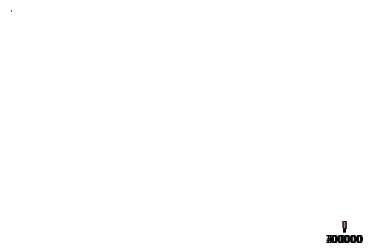

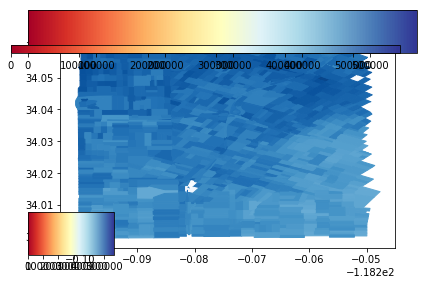

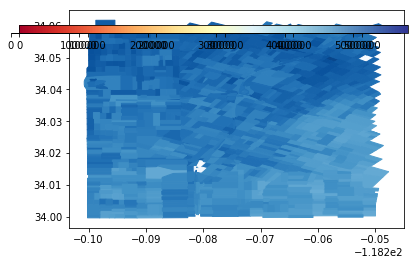

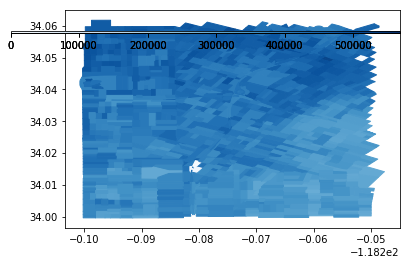

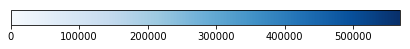

In [221]:
plt.show()